Mean partner count: 10.1
Median partner count: 3.0
Standard deviation of partner count: 15.264009958068028


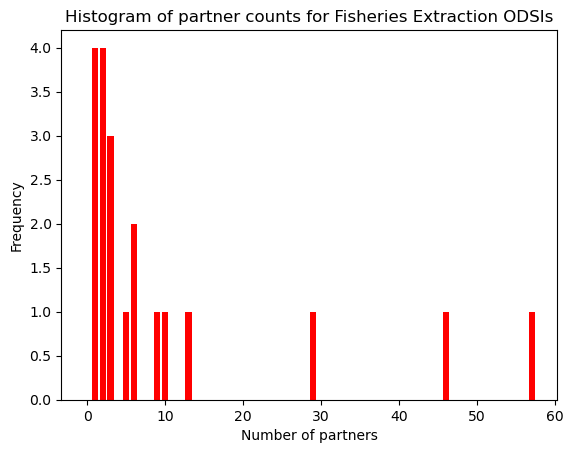

In [3]:
#IMPORTS
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re

#GRAPH OBJECT CREATION FOR SUMMARY STATS

path = "/Users/zfrancis/Documents/Personal_Work_Stuff/programs/odsi/DOGL_Repo/DOGL/analysis-tools/Network-python/data/partner_data_cleaned.csv" #Replace with your own path

# Read CSV file and create an empty graph
partners_df = pd.read_csv(path)

G = nx.Graph()

# Create color mapping
focal_color_mapping = {
    "basic science": "blue",
    "fisheries extraction": "red",
    "biodiversity conservation": "green",
    "partner": "#fdfd96"  # pastel yellow
}

# Iterate through the data and add nodes and edges to the graph
for index, row in partners_df.iterrows():
    odsi = row["ODSI"]
    list_of_partners = str(row["List of Partners"])
    focal_area = row["Focal Area"].lower()
    G.add_node(odsi, node_type="ODSI", highlight=False, focal_area=focal_area, color=focal_color_mapping[focal_area])
    if list_of_partners.lower != "not indicated":
        partners = list_of_partners.split(";")
        for partner in partners:
            partner = partner.strip()
            # Extract the abbreviation from the partner name
            partner_abbr = re.search(r'\((.*?)\)', partner)
            partner_abbr = partner_abbr.group(1) if partner_abbr else partner

            # Check if a node with the same abbreviation already exists and is an ODSI
            if any(attr.get('abbr') == partner_abbr and attr["node_type"] == "ODSI" for _, attr in G.nodes(data=True)):
                # If it is, skip adding it as a partner
                continue

            # Add partner node to the graph
            G.add_node(partner, node_type="partner", highlight=False, focal_area=focal_area, abbr=partner_abbr, color=focal_color_mapping["partner"])

            # Add edge between ODSI and partner
            G.add_edge(odsi, partner, highlight=False)
    else:
        pass

focal_area_for_analysis = 'biodiversity conservation' # Set focal area
partner_edge_counts = {}

for node, attr in G.nodes(data=True):
    if attr["node_type"] == "partner":
        # Get the edges for this node
        edges = G.edges(node)
        # Filter the edges by the focal area of the connected ODSI nodes
        filtered_edges = [edge for edge in edges if G.nodes[edge[1]]["focal_area"] == focal_area_for_analysis]
        if len(filtered_edges) > 0:
            partner_edge_counts[node] = len(filtered_edges)
        else:
            partner_edge_counts[node] = 0

partner_edge_df=pd.DataFrame.from_dict(partner_edge_counts, orient='index', columns=['Number of Edges'])
partner_edge_df = partner_edge_df.sort_values(by="Number of Edges", ascending=False)

# Summary statistics for number of partners
odsi_edge_counts = {}
for node, attr in G.nodes(data=True):
    if attr["node_type"] == "ODSI" and attr["focal_area"] == focal_area_for_analysis: 
        num_edges = len(list(G.edges(node)))
        odsi_edge_counts[node] = num_edges

odsi_edge_df = pd.DataFrame.from_dict(odsi_edge_counts, orient='index', columns=['Partner Count'])

# Calculate mean, median, and standard deviation of number of partners for each ODSI
mean_partner_count = np.mean(odsi_edge_df["Partner Count"])
median_partner_count = np.median(odsi_edge_df["Partner Count"])
std_partner_count = np.std(odsi_edge_df["Partner Count"])

print(f"Mean partner count: {mean_partner_count}")
print(f"Median partner count: {median_partner_count}")
print(f"Standard deviation of partner count: {std_partner_count}")

# Plot a histogram of partner counts for ODSIs using matplotlib
plt.hist(odsi_edge_df["Partner Count"], bins=range(0, odsi_edge_df["Partner Count"].max()+2, 1), align="left", rwidth=0.8, color='red')
plt.xlabel("Number of partners")
plt.ylabel("Frequency")
plt.title("Histogram of partner counts for Fisheries Extraction ODSIs")
plt.show()

